In [1]:
import scipy.io as spio

import tensorflow as tf
import numpy as np

mat = spio.loadmat('redu_TF_train200.mat', squeeze_me=True)
#mat = spio.loadmat('redu_transfun_train_lesssamples.mat', squeeze_me=True)

In [2]:

H2r0 = mat['Hr16'] # training data of H at the first output port
freqv_test=mat['freqv'] # testing frequency samples
freqv= mat['freqv_train'] # vector of trainining frequency samples
H2r=tf.transpose(H2r0)
freqv=tf.transpose(freqv)
nf=freqv.shape[0]

In [3]:
min_freq0 = freqv[0] 
min_freq=tf.cast(min_freq0, dtype=tf.float32)
max_freq0 = freqv[nf-1]
max_freq=tf.cast(max_freq0, dtype=tf.float32)

In [4]:
def init_model(num_hidden_layers=6, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is one-dimensional (frequency)
    model.add(tf.keras.Input(1))

     #Introduce a scaling layer to map input to [lb, ub]
    freqvcast=tf.cast(freqv, dtype=tf.float32)  
    scaling_layer = tf.keras.layers.Lambda(
                lambda freqvcast: 2.0*(freqvcast - min_freq)/(max_freq - min_freq) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
             #activation=tf.keras.activations.get('elu'),
             #kernel_initializer='glorot_normal'))
             #activation=tf.keras.layers.LeakyReLU(alpha=1),
             #kernel_initializer='glorot_normal'))
              activation=tf.math.sin,
              kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(2))
    
    return model

In [5]:
def compute_loss(model, H2r):
    
         
   # loss function
    H2r_real=tf.cast(tf.math.real(H2r), dtype=tf.float32)
    H2r_imag=tf.cast(tf.math.imag(H2r), dtype=tf.float32)
    loss=tf.reduce_mean(tf.square(H2r_real))-tf.reduce_mean(tf.square(H2r_real))
    
    Hr_pred = model(freqv)
    loss += tf.reduce_mean(tf.square(H2r_real - Hr_pred[:,0]))+tf.reduce_mean(tf.square(H2r_imag - Hr_pred[:,1]))
        
    return loss

In [6]:
def get_grad(model, H2r):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, H2r)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [7]:
# Initialize model 
model = init_model()

# We choose a piecewise decay of the learning rate.

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[0.1,0.01,0.001])

# Choose the optimizer
optim = tf.keras.optimizers.Adam()

In [8]:
from time import time

# Number of training epochs
N =13000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss, grad_theta = get_grad(model, H2r)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.79401417e+01
It 00050: loss = 1.23876390e+01
It 00100: loss = 7.53984547e+00
It 00150: loss = 4.60753489e+00
It 00200: loss = 3.35072422e+00
It 00250: loss = 2.61709356e+00
It 00300: loss = 1.38886380e+00
It 00350: loss = 6.11753106e-01
It 00400: loss = 2.90138900e-01
It 00450: loss = 1.62362650e-01
It 00500: loss = 1.04754090e-01
It 00550: loss = 7.11858794e-02
It 00600: loss = 5.19921891e-02
It 00650: loss = 4.09272909e-02
It 00700: loss = 3.39586698e-02
It 00750: loss = 3.27988863e-02
It 00800: loss = 2.56414618e-02
It 00850: loss = 2.29550228e-02
It 00900: loss = 2.11213008e-02
It 00950: loss = 1.91898029e-02
It 01000: loss = 1.78103037e-02
It 01050: loss = 1.69955529e-02
It 01100: loss = 1.56459212e-02
It 01150: loss = 1.50091080e-02
It 01200: loss = 1.40705295e-02
It 01250: loss = 1.33182993e-02
It 01300: loss = 1.28613384e-02
It 01350: loss = 1.21978149e-02
It 01400: loss = 1.21584143e-02
It 01450: loss = 1.12881400e-02
It 01500: loss = 1.08539136e-02
It 01550

It 12850: loss = 2.01603019e-04
It 12900: loss = 8.17306864e-05
It 12950: loss = 1.79062109e-03
It 13000: loss = 9.11619281e-05

Computation time: 147.03322458267212 seconds


In [9]:
t0=time()

In [10]:
upred = model(freqv_test)
# Print online computation time
print('\nOnlineComputation time: {} seconds'.format(time()-t0))


OnlineComputation time: 0.04725790023803711 seconds


In [11]:
from matplotlib import pyplot
pyplot.rcParams['text.usetex'] = True
pyplot.rcParams.update({'font.size': 10})
pyplot.rcParams['figure.figsize']=[4,3]
pyplot.rcParams["figure.dpi"]=1000
pyplot.rcParams['font.family'] = 'Helvetica'
pyplot.rcParams["lines.markersize"]=2
pyplot.rcParams["lines.linewidth"]=0.5
from scipy.io import savemat

In [12]:
upred_complex=tf.complex(upred[:,0],upred[:,1])
#pyplot.plot(freqv_test,tf.abs(upred_complex),'+r')

In [13]:
mat_test = spio.loadmat('orig_fun_test_powerbus.mat', squeeze_me=True)

In [14]:
Ho110= mat_test['Ho16'] # training data of H at the second output port
Ho11=tf.transpose(Ho110)
Ho11_real=tf.cast(tf.math.real(Ho11), dtype=tf.float32)
Ho11_imag=tf.cast(tf.math.imag(Ho11), dtype=tf.float32)

In [15]:
H,=pyplot.plot(freqv_test/1e9,tf.abs(Ho11),'b',label='H')
Hr,=pyplot.plot(freqv_test/1e9, tf.abs(upred_complex),'--r',label='Hr')
pyplot.ylabel('Magnitude')
pyplot.xlabel('Frequency (GHz)')
pyplot.legend([H, Hr], ["$H_{16}$","$H_{16}^{NN}$"])
pyplot.savefig('H16_NN_mag',bbox_inches='tight')

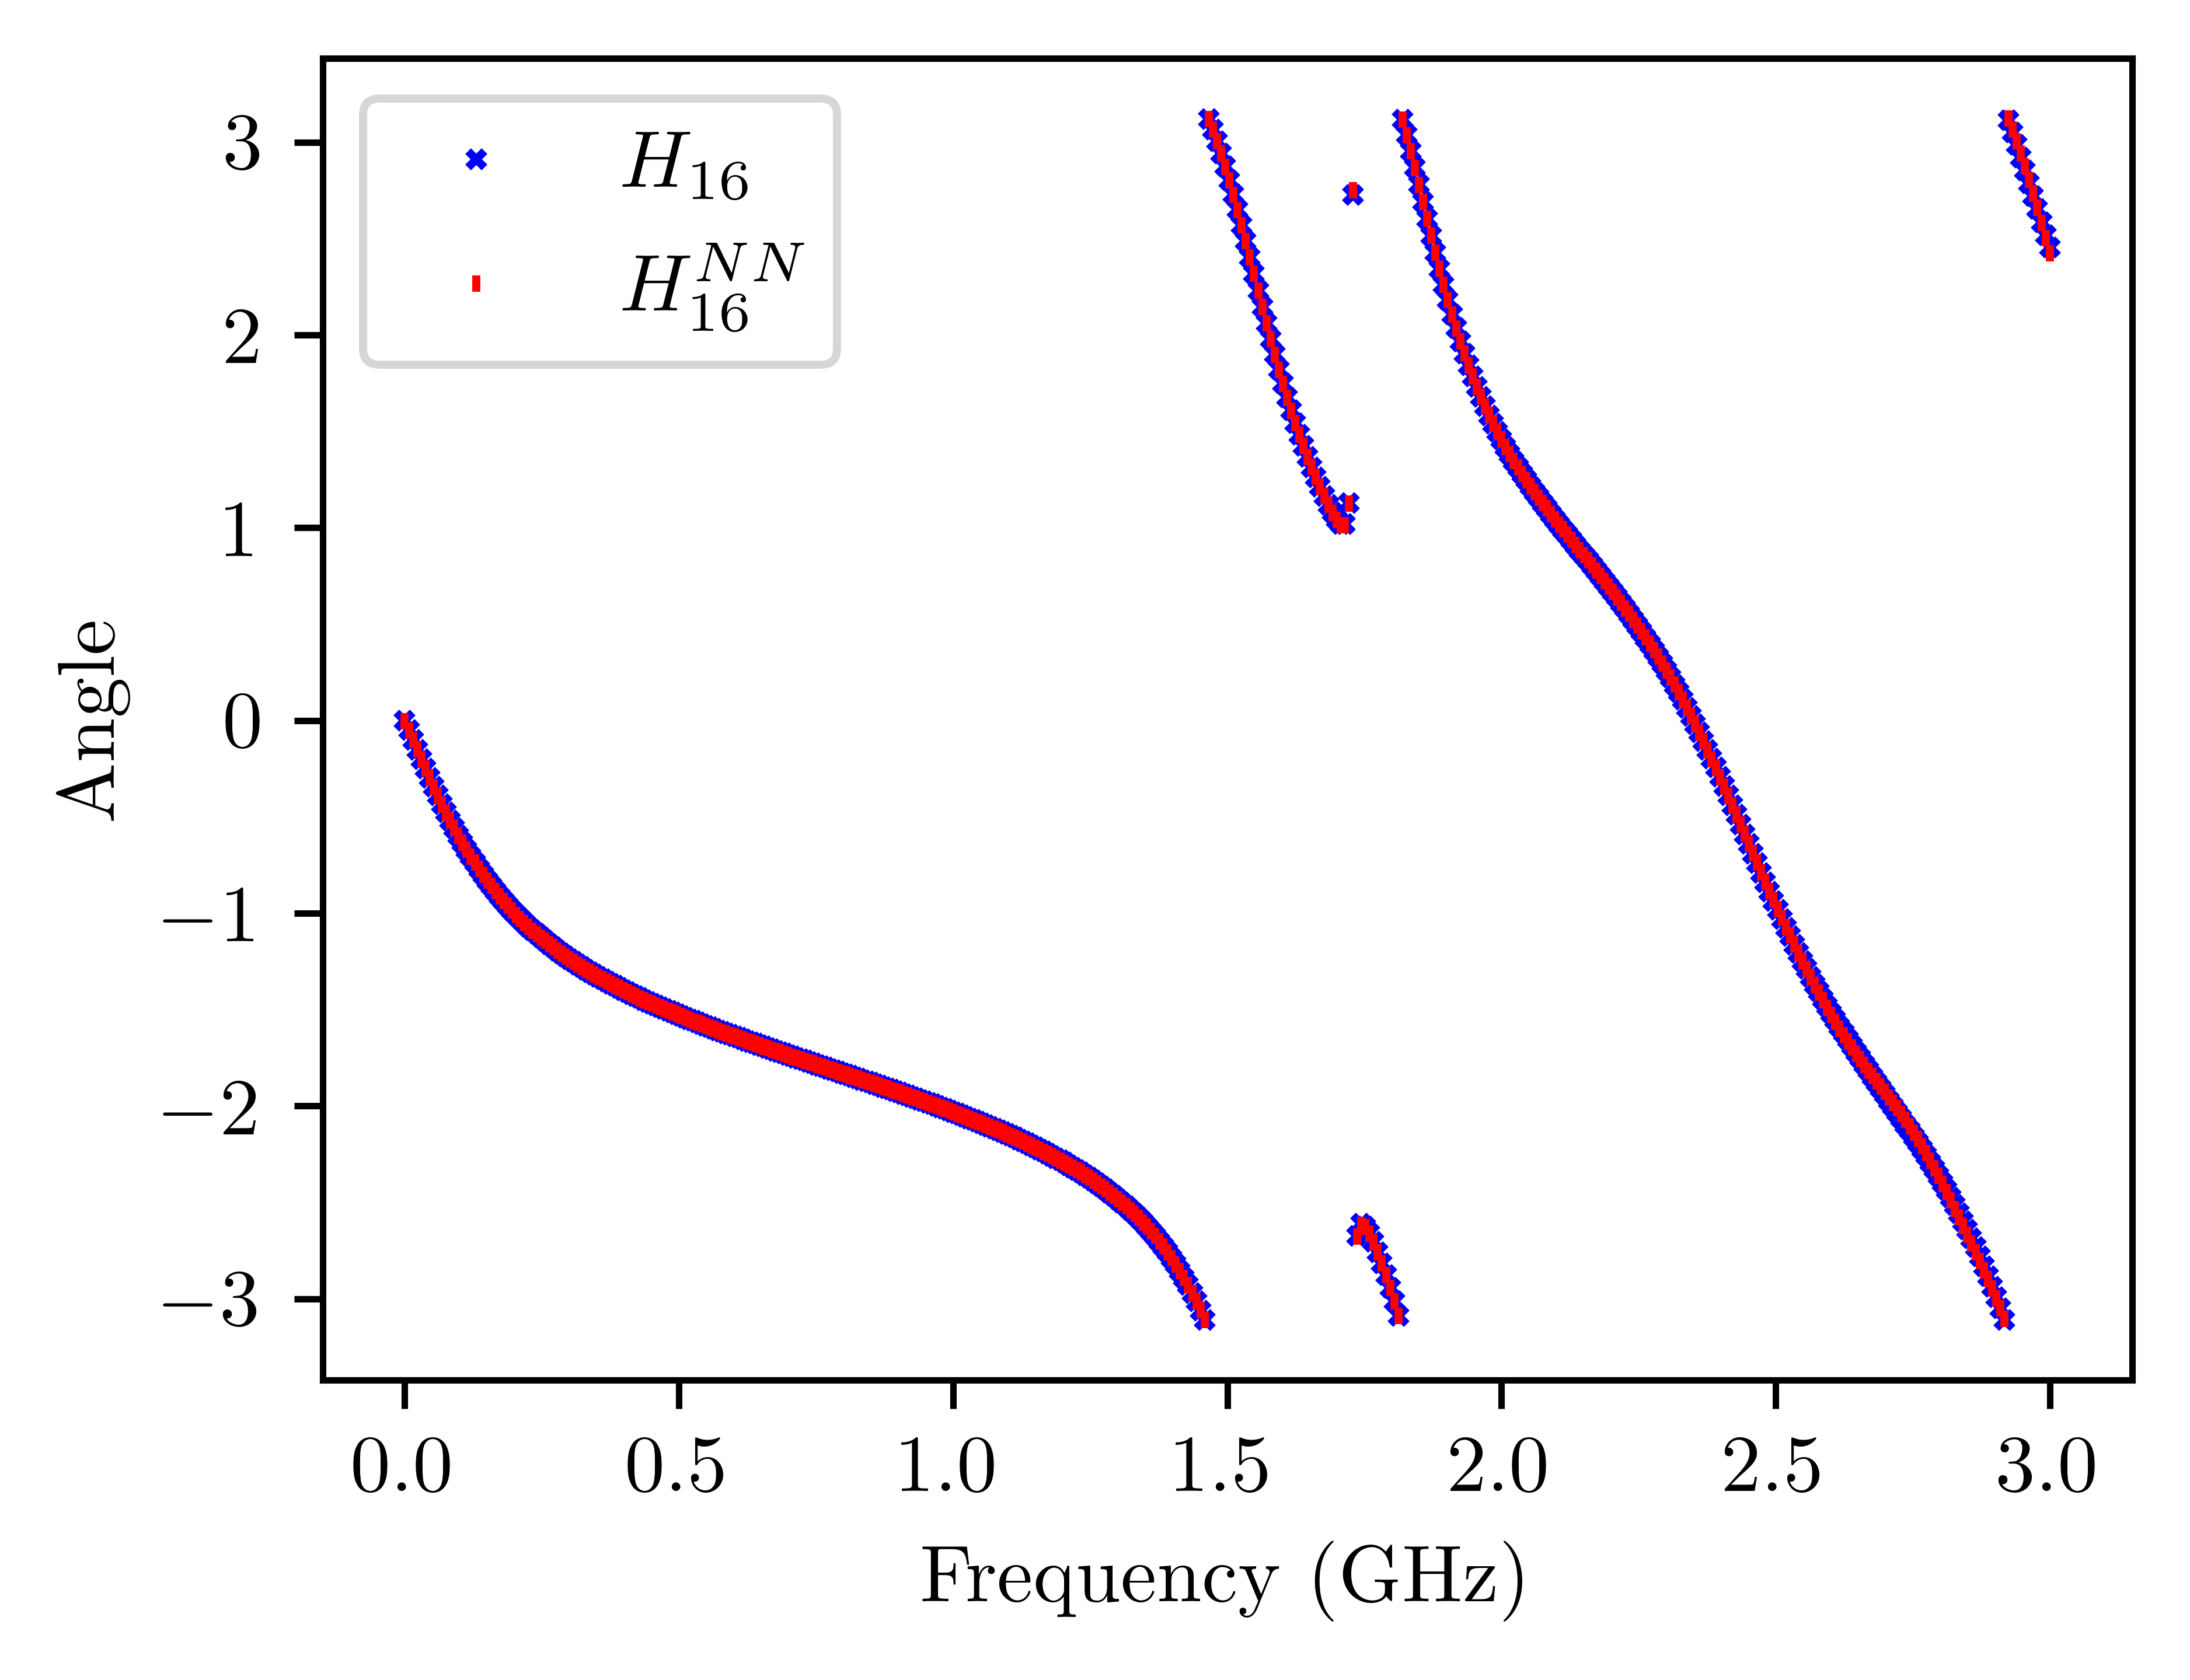

In [16]:
H,=pyplot.plot(freqv_test/1e9,tf.math.angle(Ho11),'xb',label='H')
Hr,=pyplot.plot(freqv_test/1e9, tf.math.angle(upred_complex),'|r',label='Hr')
pyplot.ylabel('Angle')
pyplot.xlabel('Frequency (GHz)')
pyplot.legend([H, Hr], ["$H_{16}$","$H_{16}^{NN}$"])
pyplot.savefig('H16_NN_angle',bbox_inches='tight')

In [17]:
Ho11=tf.cast(Ho11, dtype=tf.complex64)
eH=tf.divide(abs(Ho11-upred_complex),max(abs(Ho11)))
eH=np.array(eH);
upred=np.array(upred_complex);
mdic = {"H16NN":upred,"error":eH}
savemat("PH16NN.mat", mdic)
max(eH)

0.009960869

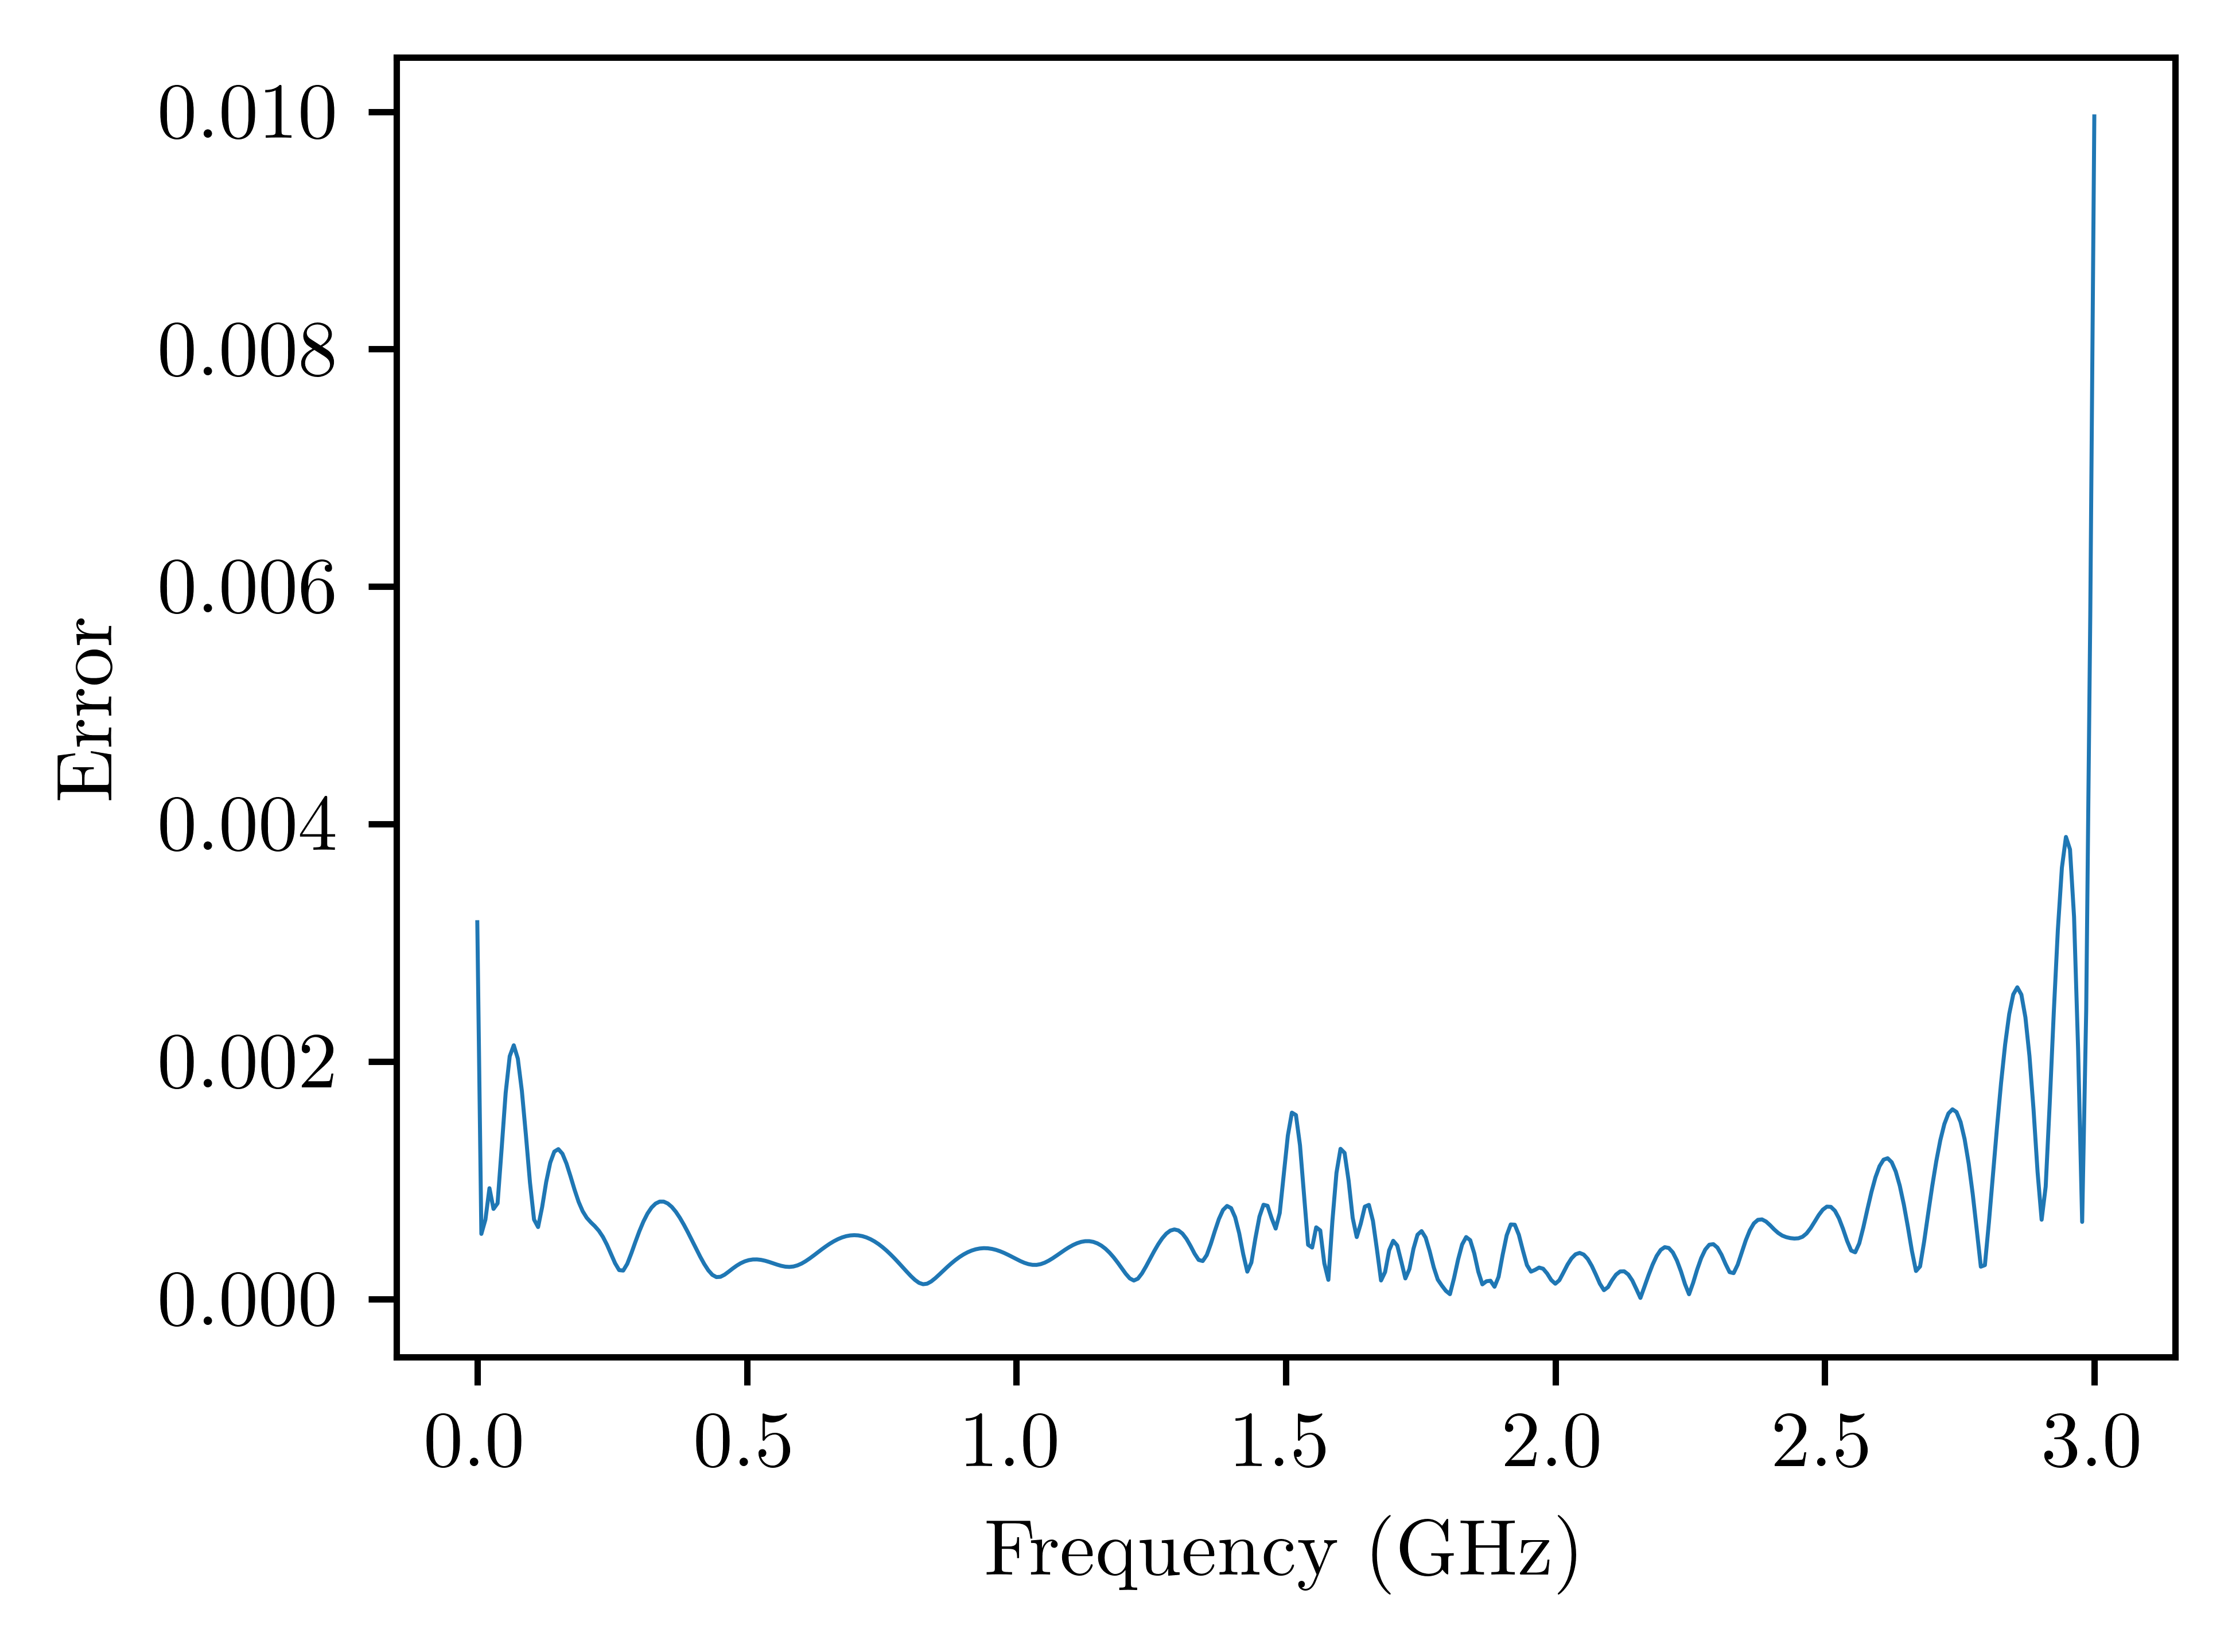

In [18]:
pyplot.plot(freqv_test/1e9,eH)
pyplot.ylabel('Error')
pyplot.xlabel('Frequency (GHz)')
pyplot.savefig('e16_NN',bbox_inches='tight')